In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

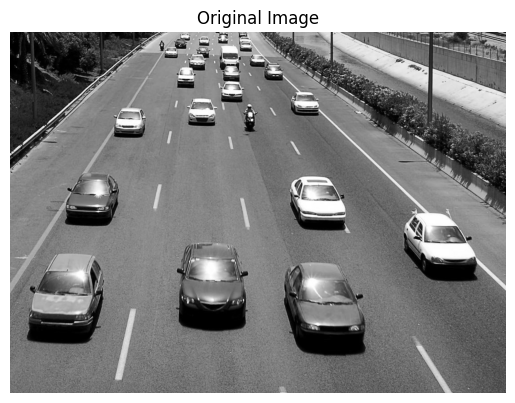

In [3]:
# Make sure your image is uploaded in Colab (Files panel, left sidebar)
# Replace 'your_image.png' with your uploaded image name
image = cv2.imread("ip", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please upload and check the filename.")

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()


In [4]:
def homogeneous(region, thresh):
    return region.max() - region.min() < thresh

def split(img, x, y, size, thresh, min_size):
    region = img[x:x+size, y:y+size]
    if size <= min_size or homogeneous(region, thresh):
        return [((x, y, size), region.mean())]
    half = size // 2
    results = []
    results += split(img, x, y, half, thresh, min_size)
    results += split(img, x, y+half, half, thresh, min_size)
    results += split(img, x+half, y, half, thresh, min_size)
    results += split(img, x+half, y+half, half, thresh, min_size)
    return results

def split_and_merge(img, thresh=15, min_size=16):
    h, w = img.shape
    size = 1 << (max(h, w)-1).bit_length()
    padded = np.zeros((size, size), dtype=img.dtype)
    padded[:h, :w] = img
    results = split(padded, 0, 0, size, thresh, min_size)
    segmented = np.zeros_like(padded, dtype=np.uint8)
    for (x, y, s), val in results:
        segmented[x:x+s, y:y+s] = int(val)
    return segmented[:h, :w]


In [5]:
def homogeneous(region, thresh):
    return region.max() - region.min() < thresh

def split(img, x, y, size, thresh, min_size):
    region = img[x:x+size, y:y+size]
    if size <= min_size or homogeneous(region, thresh):
        return [((x, y, size), region.mean())]
    half = size // 2
    results = []
    results += split(img, x, y, half, thresh, min_size)
    results += split(img, x, y+half, half, thresh, min_size)
    results += split(img, x+half, y, half, thresh, min_size)
    results += split(img, x+half, y+half, half, thresh, min_size)
    return results

def split_and_merge(img, thresh=15, min_size=16):
    h, w = img.shape
    size = 1 << (max(h, w)-1).bit_length()
    padded = np.zeros((size, size), dtype=img.dtype)
    padded[:h, :w] = img
    results = split(padded, 0, 0, size, thresh, min_size)
    segmented = np.zeros_like(padded, dtype=np.uint8)
    for (x, y, s), val in results:
        segmented[x:x+s, y:y+s] = int(val)
    return segmented[:h, :w]


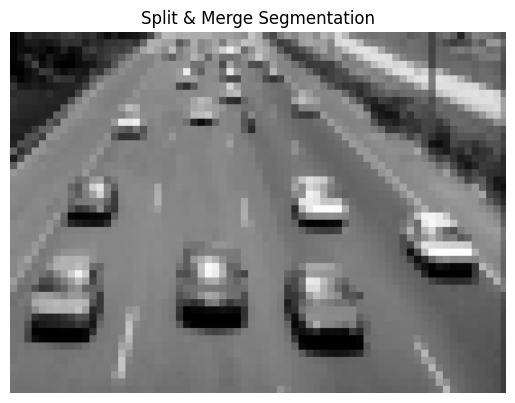

In [6]:
seg_snm = split_and_merge(image, thresh=20, min_size=16)

plt.imshow(seg_snm, cmap='gray')
plt.title("Split & Merge Segmentation")
plt.axis("off")
plt.show()


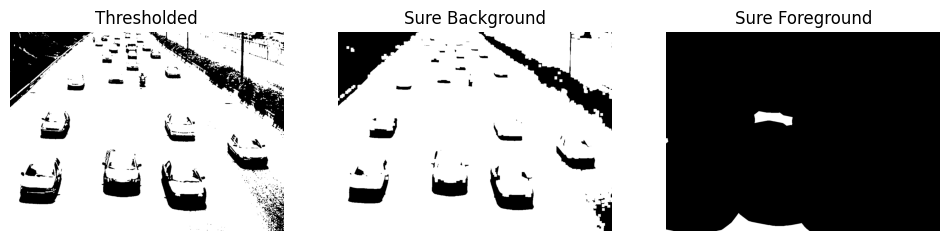

In [7]:
blurred = cv2.GaussianBlur(image, (5,5), 0)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(thresh, cmap='gray'); plt.title("Thresholded"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(sure_bg, cmap='gray'); plt.title("Sure Background"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(sure_fg, cmap='gray'); plt.title("Sure Foreground"); plt.axis("off")
plt.show()


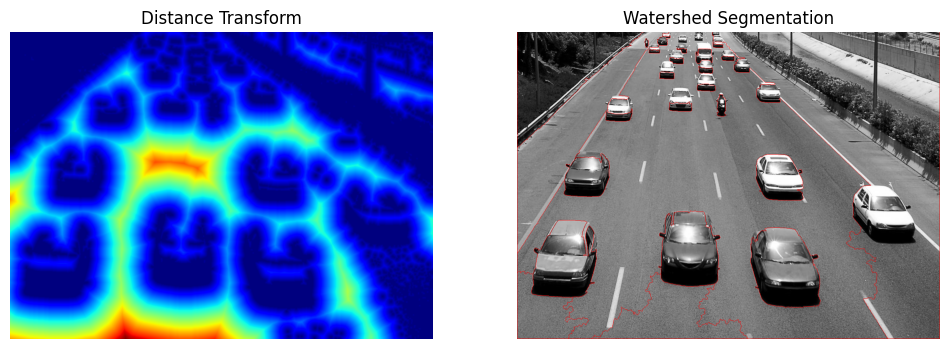

In [8]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(image_color, markers)
image_color[markers == -1] = [255, 0, 0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(dist_transform, cmap='jet'); axs[0].set_title("Distance Transform"); axs[0].axis("off")
axs[1].imshow(image_color); axs[1].set_title("Watershed Segmentation"); axs[1].axis("off")
plt.show()
